<a href="https://colab.research.google.com/github/DGkurnia/cnkproject/blob/main/BMLP_Derfansyah_Guswiranata_Kurnia_klasifikasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
#Perpustakaan untuk pengelolaan data
import numpy as np
import pandas as pd
#Grafik
import matplotlib.pyplot as plt #grafik dasar
import seaborn as sns
import datetime

In [2]:
#pelabelan untuk klasifikasi
from sklearn.preprocessing import OneHotEncoder as ohen
from sklearn.preprocessing import LabelBinarizer as labin
from sklearn.preprocessing import LabelEncoder as lenco

In [3]:
#Bagian knn(p1)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve as lencur #Kurva pemberlajaran
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix as cmatr, classification_report
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
#jika pakai multilabel
from sklearn.metrics import multilabel_confusion_matrix as mcmat

In [4]:
#Bagian klasifikasi 'randomforest'
from sklearn.ensemble import RandomForestClassifier

In [5]:
#Pengunduhan dataset ke google colab
from google.colab import files
#ke proses 'upload'

In [6]:
#proses 'upload'
uploaded = files.upload()

Saving hslclstr.csv to hslclstr.csv


In [7]:
#pengelolaan file
import os #untuk os
import time #waktu
import datetime #tanggal
import gc #pengunduhan file per batch

In [8]:
#Penyimpanan hasil sementara di google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#inisiasi berat sampel
from sklearn.utils.class_weight import compute_sample_weight as csw #inspeksi berat dulu

In [10]:
#Bagian multiprocessing melalui instalasi pool
import warnings #peringatan
import multiprocessing as mp #untuk multiprocessing
from multiprocessing import Pool
import joblib #Bagian Joblib

In [11]:
#Deklarasi klasifikasi
from sklearn.datasets import make_classification

In [12]:
#penyimpanan hasil melalui dill
! pip install dill
import dill

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.2 MB/s eta 0:00:00


# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [13]:
#Cek data hasil kluster
df = pd.read_csv('/content/hslclstr.csv')
dfc = df.copy() #jangan pakai data asli

In [14]:
#cek hasil
smpl = dfc.head(7)
inf = dfc.info() #informasi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   img                          64016 non-null  object 
 1   title                        64016 non-null  object 
 2   console                      64016 non-null  object 
 3   genre                        64016 non-null  object 
 4   publisher                    64016 non-null  object 
 5   total_sales                  64016 non-null  float64
 6   na_sales                     64016 non-null  float64
 7   jp_sales                     64016 non-null  float64
 8   pal_sales                    64016 non-null  float64
 9   other_sales                  64016 non-null  float64
 10  critic_score                 64016 non-null  float64
 11  release_date                 64016 non-null  object 
 12  last_update                  64016 non-null  object 
 13  kemungkinan gene

In [15]:
#inspeksi label untuk sampel
lbl = dfc['Label'].copy()
print(lbl.head(7))

0    game kurang berkenan dengan fokus pencarian ke...
1    game kurang berkenan dengan fokus pencarian ke...
2    game kurang berkenan dengan fokus pencarian ke...
3                game dengan tujuan utama pencari duit
4    game kurang berkenan dengan fokus pencarian ke...
5                game dengan tujuan utama pencari duit
6                game dengan tujuan utama pencari duit
Name: Label, dtype: object


Kolom ini menjadi basis sumbu y di klasifikasi

# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [16]:
#Inisiasi pembagian data
inspk = dfc.iloc[:,5:11].copy() #numerikal untuk klasifikasi kluster
inspk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   total_sales   64016 non-null  float64
 1   na_sales      64016 non-null  float64
 2   jp_sales      64016 non-null  float64
 3   pal_sales     64016 non-null  float64
 4   other_sales   64016 non-null  float64
 5   critic_score  64016 non-null  float64
dtypes: float64(6)
memory usage: 2.9 MB


In [17]:
#Sumbu x
xcls = inspk.copy() #pakai numerik

Sumbu x  **(xcls)** adalah nilai numerikal dari tabel yang terdiri dari
* Penjualan dari lima indikator (total, spesifik di amerika utara, jepang, PAL, lain-lain)
* Nilai kritik dari permainan

##Persiapan sumbu y

In [18]:
#numerisasi label (identifikasi jenis label)
jnslbl = lbl.copy()
jnslbl.info()

<class 'pandas.core.series.Series'>
RangeIndex: 64016 entries, 0 to 64015
Series name: Label
Non-Null Count  Dtype 
--------------  ----- 
64016 non-null  object
dtypes: object(1)
memory usage: 500.2+ KB


In [20]:
#Persiapan pembagian data (untuk kluster)
ycls = jnslbl #masih kata-kata
#pelabelan untuk (pembentukan ulang)
bntkbaru, label = pd.factorize(ycls, sort=True, use_na_sentinel=False)
#inspeksi hasil
print(bntkbaru)
print(label)

[2 2 2 ... 1 1 1]
Index(['game dengan tujuan utama pencari duit',
       'game favortit dengan keuntungan rendah',
       'game kurang berkenan dengan fokus pencarian keuntungan'],
      dtype='object')


sampel kolom pelabelan

In [22]:
#pembentukan ulang
enkoding = bntkbaru.reshape(-1,1).ravel()
#inisiasi ohen
encoder = lenco() #Untuk proses inti numerisasi
#penyesuaian data
lblohen = encoder.fit_transform(enkoding)

In [23]:
#konversi ke df untuk kluster jadi
dflbl = pd.DataFrame(lblohen, columns=['Biner1'], copy=True)
#Konversi ke numerik
lbl2 =  np.argmax(dflbl.values, axis=1) #demi jadi ke numerik
#Ubah kembali ke df
dflbl2 = pd.DataFrame(lbl2, columns=['Label'], copy=True)
#cek hasil
smpllbl = dflbl2.head(7)
tiplbl = dflbl2.info()
print(smpllbl) #inspeksi hasil

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Label   64016 non-null  int64
dtypes: int64(1)
memory usage: 500.2 KB
   Label
0      0
1      0
2      0
3      0
4      0
5      0
6      0


In [24]:
#Persiapan ycl
ycl = dflbl2.values.ravel() #nilai numerik

Nilai ini menjadi komponen untuk penyatuan dengan variabel **(ycls)**

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [25]:
#proses scaling untuk sumbu X (robust)
rbsscal = RobustScaler(unit_variance=True) #untuk robust [tahap 1]
stdscal = StandardScaler() #untuk standar [Tahap 2]
mmscal = MinMaxScaler(clip=True) #untuk indikator 'minmax' [Tahap 3]
xclscl = rbsscal.fit_transform(xcls) #untuk tahap 1
xclstd = stdscal.fit_transform(xclscl) #untuk tahap 2
xclmm = mmscal.fit_transform(xclstd) #untuk tahap 3
#pengubahan ke data frame untuk evaluasi tahap akhir
dfxclmm = pd.DataFrame(xclmm, columns=xcls.columns,copy=True)

In [26]:
#inspeksi kolom
print(dfxclmm.head(7))

   total_sales  na_sales  jp_sales  pal_sales  other_sales  critic_score
0     1.000000  0.652664  0.464789   1.000000     1.000000      0.933333
1     0.954232  0.620902  0.281690   0.985787     0.967949      0.966667
2     0.794783  0.861680  0.220657   0.557360     0.570513      0.955556
3     0.780512  0.928279  0.028169   0.541117     0.455128      0.955556
4     0.742618  0.633197  0.192488   0.614213     0.782051      0.788889
5     0.729331  0.929303  0.061033   0.435533     0.426282      0.855556
6     0.725394  1.000000  0.051643   0.378680     0.365385      0.866667


In [27]:
#Deskripsi nilai
desxcl = dfxclmm.describe()
print(desxcl)

        total_sales      na_sales      jp_sales     pal_sales   other_sales  \
count  64016.000000  64016.000000  64016.000000  64016.000000  64016.000000   
mean       0.005078      0.005876      0.014098      0.003358      0.003391   
std        0.022982      0.025104      0.045567      0.018919      0.020624   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000984      0.001025      0.004695      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       critic_score  
count  64016.000000  
mean       0.671845  
std        0.172228  
min        0.000000  
25%        0.577778  
50%        0.700000  
75%        0.788889  
max        1.000000  


6 kolom di dataframe 'dfxclmm' menjadi aspek di sumbu **"x"**

Nilai salinan dflbl menjadi basis variabel **'ycl'**

In [28]:
#deklarasi nilai X dan y
X_train, X_test, y_train, y_test = train_test_split(xclmm, ycl, test_size=0.25, random_state=35, stratify=ycl) #untuk cek kondisi 1
X_train2, X_test2, y_train2, y_test2 = train_test_split(xclmm, ycl, test_size=0.225, random_state=35, stratify=ycl) #untuk KOndisi 2

In [31]:
#Berat sampel di latihan untuk penstabilan
brtsmplth = csw(class_weight='balanced', y=y_train) #dipakai di kondisi 1
brtsmplth2 = csw(class_weight='balanced', y=y_train2) #dipakai di kondisi 2

In [32]:
#Inisiasi 'berat sampel' di data tes
brtsampel = csw(class_weight='balanced', y=y_test) #dipakai di kondisi 1
brtsampel2 = csw(class_weight='balanced', y=y_test2) #dipakai di kondisi 2

- Tujuan pemasan berat di latihan adalah penstabilan data dengan indisitas
- Indisitas dengan '1' dan '2' menyatakan kondisi rasio dalam analisis data

In [33]:
#Lihat bentuk berat (latihan)
print(brtsmplth)
print(brtsmplth2)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


In [34]:
#Bentuk berat (tes)
print(brtsampel)
print(brtsampel2)

[1. 1. 1. ... 1. 1. 1.]
[1. 1. 1. ... 1. 1. 1.]


Rincian Percobaan
* Percobaan pertama untuk kedua metode berlangsung dengan rasio (3/1) (1)
* Percobaan kedua dengan rasio (31/9)

In [35]:
#Fungsi penentu akurasi melalui KNN
def train_and_evaluate(k):
    model = KNeighborsClassifier(n_neighbors=k, weights='distance', leaf_size=35,
                                 metric='seuclidean',p=1,metric_params={'V': np.var(X_train, axis=0)})
    #Tahap 'ravelisasi'
    y_trainrav = y_train.ravel()
    model.fit(X_train, y_trainrav) #Untuk ravelisasi (penekanan hasil ke model 1 dimensi)

    #Prediksi
    y_pred = model.predict(X_test)

    # Pembulatan metrik
    accuracy = accuracy_score(y_test, y_pred, sample_weight=brtsampel) # Akurasi yang dinormalkan
    precision = precision_score(y_test, y_pred, average='weighted', sample_weight=brtsampel, zero_division=0) # Penyesuaian di presisi
    recall = recall_score(y_test, y_pred, average='weighted',sample_weight=brtsampel, zero_division=0) #Penyesuaian di kondisi recall
    f1 = f1_score(y_test, y_pred, average='weighted',sample_weight=brtsampel, zero_division=0) #Penyesuaian di skor F1

    # Print metrics
    print(f"Total Tetangga k= {k}")
    print(f"Nilai Akurasi: {accuracy:.4f}, Presisi: {precision:.4f}, Aspek Recall: {recall:.4f}, Skor F1: {f1:.4f}")

    # Classification report
    report = classification_report(y_test, y_pred, sample_weight=brtsampel, zero_division=0)

    if (accuracy >= 0.87 and precision >= 0.87 and recall >= 0.87 and f1 >= 0.87) or \
       (accuracy >= 0.92 and precision >= 0.92 and recall >= 0.92 and f1 >= 0.92):
        print("Hasil sangat bagus untuk disimpan bisa disimpan.")
        return (k, accuracy, precision, recall, f1, y_pred, report)
    elif (accuracy >= 0.87 and precision >= 0.87 and recall >= 0.87 and f1 >= 0.87) or \
         (accuracy < 0.92 and precision < 0.92 and recall < 0.92 and f1 < 0.92):
        print("Hasil masih bisa disimpan.")
        return (k, accuracy, precision, recall, f1, y_pred, report)
    elif (accuracy >= 0.87 and precision >= 0.87 and recall < 0.87 and f1 < 0.87) or \
         (accuracy > 0.92 and precision > 0.92 and recall < 0.92 and f1 < 0.92):
         print("Ada masalah di recall dan nilai f1.")
         return None
    else:
        print("Hasil tidak pantas disimpan.")
        return None
  #ke pembentukan matriks

In [36]:
#Fungsi evaluasi matriks
def generate_confusion_matrix(y_true, y_pred, brtsampel):
    cm = cmatr(y_true, y_pred, sample_weight=brtsampel, normalize='all') #Bisa matriks biasa atau multi matriks
    print("Confusion Matrix:")
    cm_rounded = np.round(cm.astype(float), decimals=4)  # Pembulatan untuk kemudahan nilai
    print("Hasil Confusion Matriks:")
    print(cm_rounded)
    return cm_rounded #Hasil untuk pembulatan
#ke eksekusi asli

In [37]:
#Deklarasi parameter batas di KNN
param_grid = range(3,13)
#Paralelisasi melalui KNN
if __name__ == '__main__':
    with Pool() as pool:
        results = pool.map(train_and_evaluate, param_grid)

    # Filter out empty results
    filtered_results = [result for result in results if result is not None]

    # Get the best result
    best_result = max(filtered_results, key=lambda x: x[1], default=None)

    if best_result:
        # Pembulatans
        rounded_best_result = (
            best_result[0],  # Nilai awal
            round(best_result[1], 3),  # Pembulatan 1
            round(best_result[2], 3),  # Pembulatan 2
            round(best_result[3], 3),  # Pembulatan 3
            round(best_result[4], 3),  # Pembulatan 4
            best_result[5],  # Predictions (y_pred)
            best_result[6]   # Informasi tambahan
        )

        # Simpan nilai terbaik dari dill
        with open('best_knn_result.dill', 'wb') as f:
            dill.dump(rounded_best_result, f)

        #Implementasi hasil terbaik
        _, _, _, _, _, y_pred, _ = rounded_best_result
        cm = generate_confusion_matrix(y_test, y_pred, brtsampel)

        # Simpan hasil matriks terbaik saja
        with open('best_confusion_matrix.dill', 'wb') as cm_file:
            dill.dump(cm, cm_file)

        # Print the best rounded result
        print("Hasil Terbaik :", rounded_best_result)
#eksekusi KNN

Total Tetangga k= 3
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus untuk disimpan bisa disimpan.
Total Tetangga k= 5
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus untuk disimpan bisa disimpan.
Total Tetangga k= 4
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus untuk disimpan bisa disimpan.
Total Tetangga k= 6
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus untuk disimpan bisa disimpan.
Total Tetangga k= 7
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus untuk disimpan bisa disimpan.
Total Tetangga k= 9
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus untuk disimpan bisa disimpan.
Total Tetangga k= 8
Nilai Akurasi: 1.0000, Presisi: 1.0000, Aspek Recall: 1.0000, Skor F1: 1.0000
Hasil sangat bagus u

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [38]:
#Inisiasi joblib di RFC untuk mempercepat inspeksi
filename = '/tmp/dataset.joblib'
joblib.dump(np.asfortranarray(X_train), filename)
X_train_mmap = joblib.load(filename, mmap_mode='r')

In [40]:
#Tahap pertama RFC (pelacakan nilai ccp alpha)
nialpf = np.arange(1e-3, 0.11, 1e-3) #Nilai alfa
itmaks = 300
tolerance = 4.8e-3
best_alpha = None
best_accuracy = -np.inf
best_f1 = -np.inf
previous_best_accuracy = None
#ke deklarasi berat sampel

In [41]:
#Persiapan kamus berat sampel untuk evaluasi ccp alfa
klsbrt = np.unique(y_train) #kelas berat di RFC
brtsmplth = csw(class_weight='balanced', y=y_train) #nilai deklarasi
dictbrt = dict(zip(klsbrt, brtsmplth)) #dideklarasikan sebagai kampus

In [42]:
#Fungsi inspeksi nilai ccp alpha optimal
def evaluasi_alfa(alpha):
    rfc = RandomForestClassifier(n_estimators=105, max_depth=8, n_jobs=1 , random_state= 35, ccp_alpha=alpha, class_weight=dictbrt ,warm_start=True)
    #Perataan menjadi satu dimensi
    y_trainr = y_train.ravel() #Sudah dalam satu dimensi

    rfc.fit(X_train_mmap, y_trainr, sample_weight=brtsmplth)

    y_pred = rfc.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred, sample_weight=brtsampel)

    # Pembulatan akurasi
    accuracy_rounded = round(accuracy, 3)
    # Penghindaran Peringatan di normalisasi
    f1 = f1_score(y_test, y_pred, average='weighted', sample_weight=brtsampel, zero_division=0)  # Nilai f1
    precision = precision_score(y_test, y_pred, average='weighted', sample_weight=brtsampel, zero_division=0)  # indikator presisi
    recall = recall_score(y_test, y_pred, average='weighted', sample_weight=brtsampel, zero_division=0)  # Nilai Recall

    return alpha, accuracy_rounded, f1, precision, recall  # Return values

# Iterasi melalui jangkauan nilai alfa
for iteration in range(itmaks):
    with Pool() as pool:
        results = pool.map(evaluasi_alfa, nialpf)

    for alpha, accuracy, f1, precision, recall in results:
        if accuracy > best_accuracy or (accuracy == best_accuracy and f1 > best_f1):
            best_alpha = alpha
            best_accuracy = accuracy
            best_f1 = f1

        # Pemeriksaan untuk nilai minimal (atau optimal)
        if (accuracy >= 0.92 and precision >= 0.92 and
            recall >= 0.92 and f1 >= 0.92) or \
           (accuracy >= 0.87 and precision >= 0.87 and
            recall >= 0.87 and f1 >= 0.87):
            print(f"Saat NIlai ccp_alpha: {alpha}, Nilai sudah memenuhi syarat"
                  f"Akurasi: {accuracy:.3f}, F1 Score: {f1:.2f}, "
                  f"Precision: {precision:.2f}, Recall: {recall:.2f}. Stopping search.")
            break

    # Pengaturan Nilai alfa
    nialpf = np.linspace(max(0.001, best_alpha - 0.005), min(0.1, best_alpha + 0.005), num=10)

    # Check for tolerance to stop early
    if iteration > 0 and abs(best_accuracy - previous_best_accuracy) < tolerance:
        print("Penghentian terjadi karena sudah melewati batas toleransi.")
        break

    previous_best_accuracy = best_accuracy

# Final results output
print(f'Nilai ccp_alpha terbaik: {best_alpha}, Accuracy: {best_accuracy:.3f}, F1 Score: {best_f1:.2f}')
#ke fungsi RFC

Saat NIlai ccp_alpha: 0.001, Nilai sudah memenuhi syaratAkurasi: 1.000, F1 Score: 1.00, Precision: 1.00, Recall: 1.00. Stopping search.
Saat NIlai ccp_alpha: 0.001, Nilai sudah memenuhi syaratAkurasi: 1.000, F1 Score: 1.00, Precision: 1.00, Recall: 1.00. Stopping search.
Penghentian terjadi karena sudah melewati batas toleransi.
Nilai ccp_alpha terbaik: 0.001, Accuracy: 1.000, F1 Score: 1.00


In [43]:
#Tahap Perhitungan melalui ravelisasi (penekanan)
y_trainr = y_train.ravel()
#eksekusi akhir
final_model = RandomForestClassifier(random_state=38, ccp_alpha=best_alpha, class_weight=dictbrt ,warm_start=True)
final_model.fit(X_train_mmap, y_trainr, sample_weight=brtsmplth) #harus kumpulan data
y_pred_final = final_model.predict(X_test)
#Ke evaluasi

In [44]:
#Persiapan label
rfcln = np.unique(y_trainr)

In [45]:
#evaluasi melalui laporan dan 'confusion matrix'
conf_matrix = np.round(cmatr(y_test, y_pred_final, labels=rfcln, sample_weight=brtsampel, normalize='all'), 4)
class_report = classification_report(y_test, y_pred_final, labels=rfcln, sample_weight=brtsampel, zero_division=0)
#pencetakan nilai matriks
print("Confusion Matrix:")
print(conf_matrix)
print("\nLaporan Klasifikasi:")
print(class_report)

Confusion Matrix:
[[1.]]

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   16004.0

    accuracy                           1.00   16004.0
   macro avg       1.00      1.00      1.00   16004.0
weighted avg       1.00      1.00      1.00   16004.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Tulis narasi atau penjelasan algoritma yang Anda gunakan.
### Rincian pemakaian algoritma KNN (K-nearest Neighboorhood)
1. Persiapan numerisasi label **'labelencoder'**
2. Proses standardisasi kolom numerik dengan **"Robustscaler","Standard Scaler", dan "Minmax Scaler"** secara berurutan
3. Persiapan berat di data untuk menghindari ketidak seimbangan
4. Eksekusi dengan teknik KNN melalui beberapa tahap :
#### 3.a. Proses Penentuan parameter di metode K-nearestNeighborhood dengan pemberat di data latihan
#### 3.b. Proses Paralelisasi untuk eksekusi dan evaluasi
#### 3.c. Tahap pencetakan Nilai akurasi, presisi, 'recall', dan skor f1
### Rincian pemkaian algoritma RFC (Random Forest Classifier)
* Persiapan numerisasi label dengan metode sama dengan KNN
* proses standardisasi dengan metode sama (agar lebih adil)
* Penerapan berat di data
* Eksekusi fungsi yang terdiri dari :
** a. Pelatihan RFC dengan RandomSearch CV untuk modifikasi nanti
** b. Tahapan paralelisasi untuk RFC
** c. Tahap pencetakan nilai RFC

(Semua metode memakai pemberatan untuk menghindari kasus bias dari data)

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

Tulis hasil evaluasi algoritma yang digunakan, jika Anda menggunakan 2 algoritma, maka bandingkan hasilnya.

## Evaluasi algoritma antara Hasil 'tetangga terdekat' dengan teknik 'randomforest'
### Evaluasi dengan teknik KNN
#### 1. Hasil mengalmi fluktuasi rendah nilai akurasi presisi indeks 'recall' dan skor f1
#### 2. Nilai masih belum mencapai akurasi minimal walau nilai dipasang pemberat
#### 3. Ada perkembangan pembentukan cluster setelah standardisasi 3 tahap
### Evaluasi dnegan teknik RFC
#### a. Nilai masih terlalu rendah baik tanpa pemberatan ataupun pemberatan
#### b.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

## Modifikasi di teknik KNN

In [46]:
#Persiapn untuk kamus berat
klsbrt = np.unique(y_train) #kelas berat
brtsmplth = csw(class_weight='balanced', y=y_train) #nilai deklarasi
dictbrt = dict(zip(klsbrt, brtsmplth)) #dideklarasikan sebagai kampus
#iterasi pelabelan
kode = np.array([dictbrt.get(label, 1.0) for label in y_test]) #Kode untuk pemberat
#Inisiasi grid search di KNN
def tuned_train_and_evaluate(X_train, y_train, X_test, y_test, kode):
    #Peringatan error
    if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
        raise ValueError("Training data contains NaN values.")

  # Definisikan nilai sampel
    knn = KNeighborsClassifier(weights='distance', leaf_size=35,
                               metric='euclidean', p=1,)

    # Define parameter distribution for RandomizedSearchCV
    param_dist = {
        'n_neighbors': range(2, min(20, len(X_train))),  # kepastian jarak tetangga sesuai
        'weights': ['uniform', 'distance'],
        'metric': ['seuclidean', 'cosine']
    }


    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(knn, param_distributions=param_dist,
                                       verbose=1, n_iter=20, cv=5,
                                       random_state=40, n_jobs=-1)

    # Konversi hasil ke 1 dimensi
    y_trainrav = y_train.ravel()

    try:
        # Pengurusan nilai eror
        random_search.fit(X_train, y_trainrav)
    except Exception as e:
        print(f"Error during fitting: {e}")
        return None

    # Prediksi Nilai dengan Randomsearch
    y_pred = random_search.predict(X_test)

    # Perhitungan matrik
    accuracy = accuracy_score(y_test, y_pred, sample_weight=kode)
    precision = precision_score(y_test, y_pred, average='weighted', sample_weight=kode)
    recall = recall_score(y_test, y_pred, average='weighted', sample_weight=kode)
    f1 = f1_score(y_test, y_pred, average='weighted', sample_weight=kode)

    # Print metrics and best parameters
    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    report = classification_report(y_test, y_pred)

    return (random_search.best_params_['n_neighbors'], accuracy, precision, recall, f1, y_pred, report)
  #ke tuning lanjutan

In [47]:
#Lanjutan tuning di KNN (matriks)
def tuned_confusion_matrix(y_true, y_pred):
    cm = cmatr(y_true, y_pred,sample_weight=kode, normalize='all')
    print("Confusion Matrix:")
    cm_rounded = np.round(cm.astype(float), decimals=4)  # Pembulatan untuk kemudahan nilai
    print("Hasil Confusion Matriks:")
    print(cm_rounded)
    return cm_rounded
#ke eksekusi akhir

In [48]:
#Eksekusi dengan modifikasi 'Randomized search'
if __name__ == '__main__':
    # Definisi pemberatan
    result = tuned_train_and_evaluate(X_train, y_trainr, X_test, y_test, kode)

    if result:
        k_value = result[0]
        rounded_results = tuple(round(x, 3) if isinstance(x, float) else x for x in result)

        # Simpan nilai terbaik dari dill
        with open('tuned_knn_result.dill', 'wb') as f:
            dill.dump(rounded_results, f)

        _, _, _, _, _, y_pred, _ = rounded_results
        cm2 = generate_confusion_matrix(y_test, y_pred,brtsampel)

        # Simpan hasil matriks terbaik saja
        with open('tuned_confusion_matrix.dill', 'wb') as cm_file:
            dill.dump(cm2, cm_file)

        # Print the best rounded result
        print("Best Result:", rounded_results)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-package

Best Parameters: {'weights': 'distance', 'n_neighbors': 6, 'metric': 'cosine'}
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1 Score: 1.0000
Confusion Matrix:
Hasil Confusion Matriks:
[[1.]]
Best Result: (6, 1.0, 1.0, 1.0, 1.0, array([0, 0, 0, ..., 0, 0, 0]), '              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     16004\n\n    accuracy                           1.00     16004\n   macro avg       1.00      1.00      1.00     16004\nweighted avg       1.00      1.00      1.00     16004\n')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Aspek modifikasi:
1. Implementasi dua metode pemberat (seuclidian dan nilai parameter 'brtsmplth')
2. Nilai cosine bertujuan untuk inspeksi sudut pada akurasi

## Modifikasi metode RFC

In [49]:
#Tahap awal di RCT (deklarasi parameter)
rcfparam = {'ccp_alpha': np.arange(1.75e-4, 0.175, 1.75e-4),'n_estimators':[100, 150, 200],
            'max_depth':[1,10,20,30],'min_samples_split': [2, 5, 10],'class_weight': ['balanced', 'distance']} #Parameter berat

In [50]:
#Lanjutan di RCT (Fungsi pengacakan)
def rfc_randomized(X_train, y_train):
#Persiapan berat sampel
    klsbrt = np.unique(y_train) #kelas berat di RFC
    brtsmplth = csw(class_weight='balanced', y=y_train) #nilai deklarasi
    dictbrt = dict(zip(klsbrt, brtsmplth)) #dideklarasikan sebagai kampus
    #Inisiasi rfc dalam randomized
    rfc2 = RandomForestClassifier(random_state=50, class_weight=dictbrt ,warm_start=True, verbose=1)
    #Penyetelan Randomsearch CV
    random_search = RandomizedSearchCV(estimator=rfc2, param_distributions=rcfparam,
                                       n_iter=100,scoring='f1_weighted',
                                       cv=6, verbose=2,
                                       random_state=42,
                                       n_jobs=-1)
    # Tahap Fitting
    random_search.fit(X_train, y_train)
    # Pengembalian Hasil
    return random_search.best_estimator_, random_search.best_params_ #
  #ke persiapan verbose

In [52]:
#Tahap 'ravel'isasi
y_trainr = y_train.ravel()
#Pemangilan hasil (Eksekusi)
randmod , randparam = rfc_randomized(X_train_mmap, y_trainr)
#Prediksi dengan randomized search
ypred_rnd = randmod.predict(X_test)
#Evaluasi hasil randomizedsearch melalui matriks dan laporan
cmatrand = cmatr(y_test, y_pred_final, sample_weight=brtsampel, normalize='all') #pasca modifikasi
laporan = classification_report(y_test, y_pred_final, sample_weight=brtsampel, zero_division=0)

# Cetak Hasil parameter modifikasi
print(f'Best Parameters: {randmod}')
print("Inspeksi Matriks Kebingungan:")
print(cmatrand)
print("\nLaporan Klasifikasi:")
print(laporan)

Fitting 6 folds for each of 100 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
306 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
197 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

Best Parameters: RandomForestClassifier(ccp_alpha=0.0385, class_weight='balanced', max_depth=30,
                       random_state=50, verbose=1, warm_start=True)
Inspeksi Matriks Kebingungan:
[[1.]]

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   16004.0

    accuracy                           1.00   16004.0
   macro avg       1.00      1.00      1.00   16004.0
weighted avg       1.00      1.00      1.00   16004.0



[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

In [53]:
#Deklarasi Label
label = ['game favortit dengan keuntungan rendah', 'game kurang berkenan dengan fokus pencarian keuntungan', 'game dengan tujuan utama pencari duit']

Basis untuk inspeksi analisis kluster

In [54]:
#Pengubahan nama untuk inspeksi di metode K-NearestNeighborhood (Normal)
hslcmatk = cm #Hasil dari K-Nearest Neighborhood
hslcmatr = conf_matrix #Hasil dari Randomforest classifier

In [55]:
#Modifikasi Randomizedsearch CV
hslmoda = cm2 #Hasil dari Randomizedsearch CV untuk K-nearest
hslmodb = cmatrand #Hasil dari Randomizedsearch CV untuk RFC
#ke ilustrasi matriks

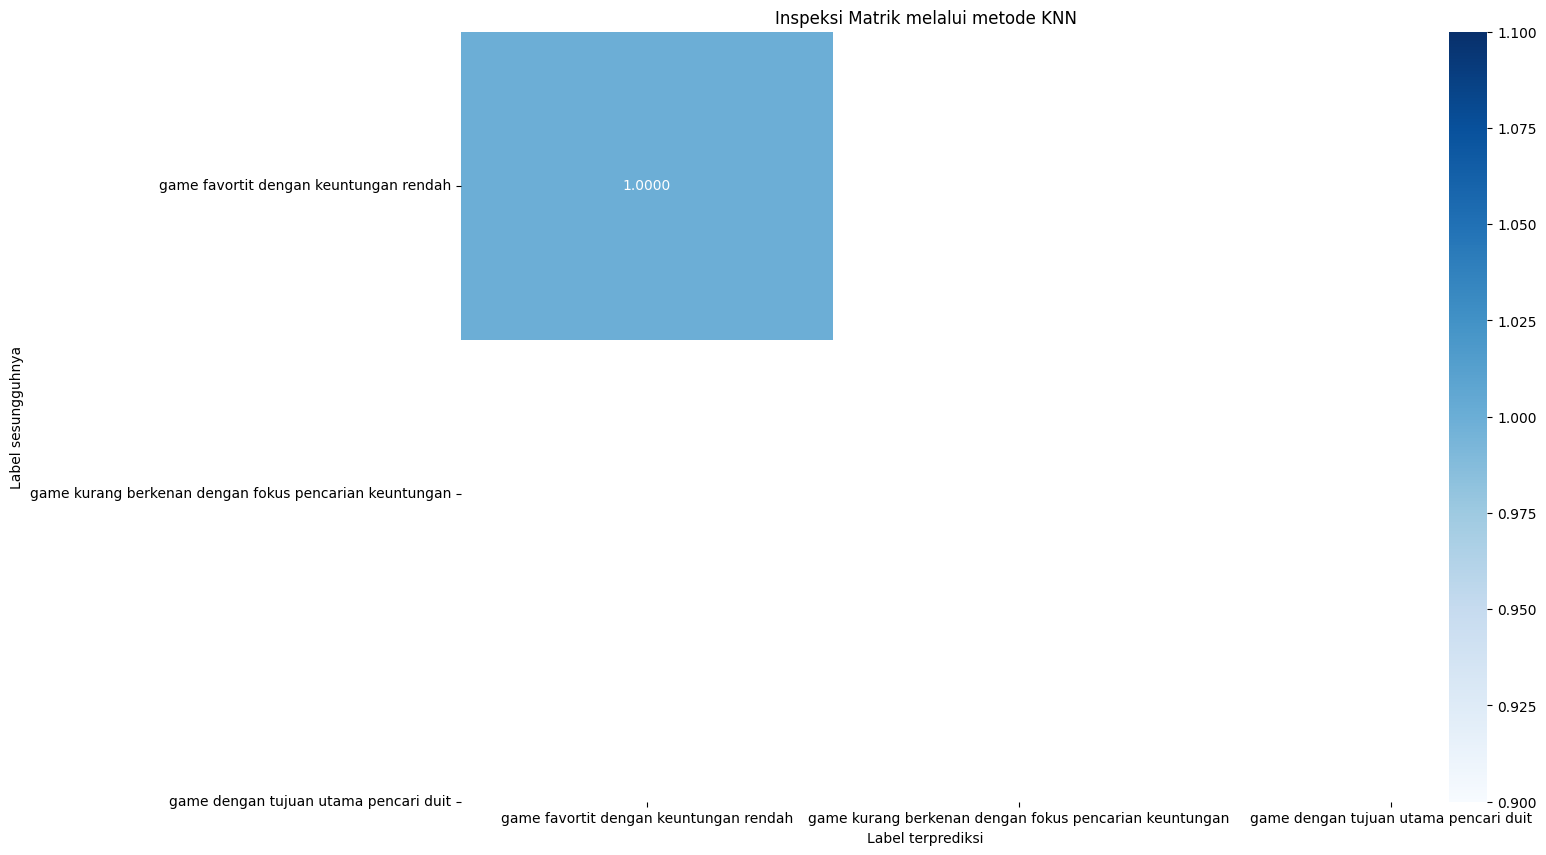

In [56]:
#Inspeksi metode 'KNN' melalui ilustrasi matriks (normal)
plt.figure(figsize=(15, 10))
sns.heatmap(hslcmatk, annot=True, fmt='.4f', cmap='Blues',
            xticklabels= label,  # Setel sesuai kelas
            yticklabels= label)  # Penyetaln kondisi
plt.ylabel('Label sesungguhnya')
plt.xlabel('Label terprediksi')
plt.title('Inspeksi Matrik melalui metode KNN')
plt.show()

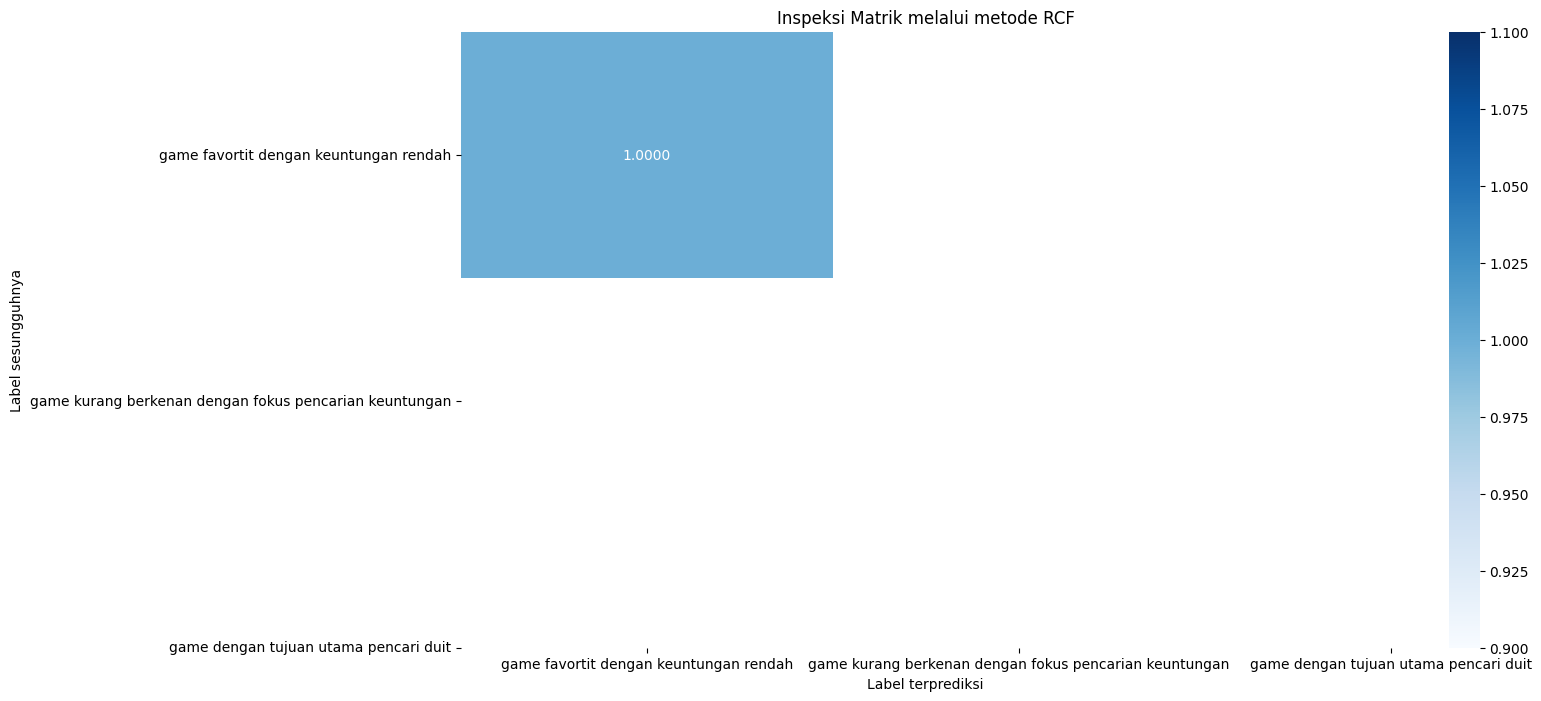

In [57]:
#Inspeksi di metode RandomForestClasifier [Normal]
plt.figure(figsize=(15, 8))
sns.heatmap(hslcmatr, annot=True, fmt='.4f', cmap='Blues',
            xticklabels= label,  # Inspeksi Sesuai Kelas
            yticklabels= label)  # Pengaturan sesuai kelas
plt.ylabel('Label sesungguhnya')
plt.xlabel('Label terprediksi')
plt.title('Inspeksi Matrik melalui metode RCF')
plt.show()

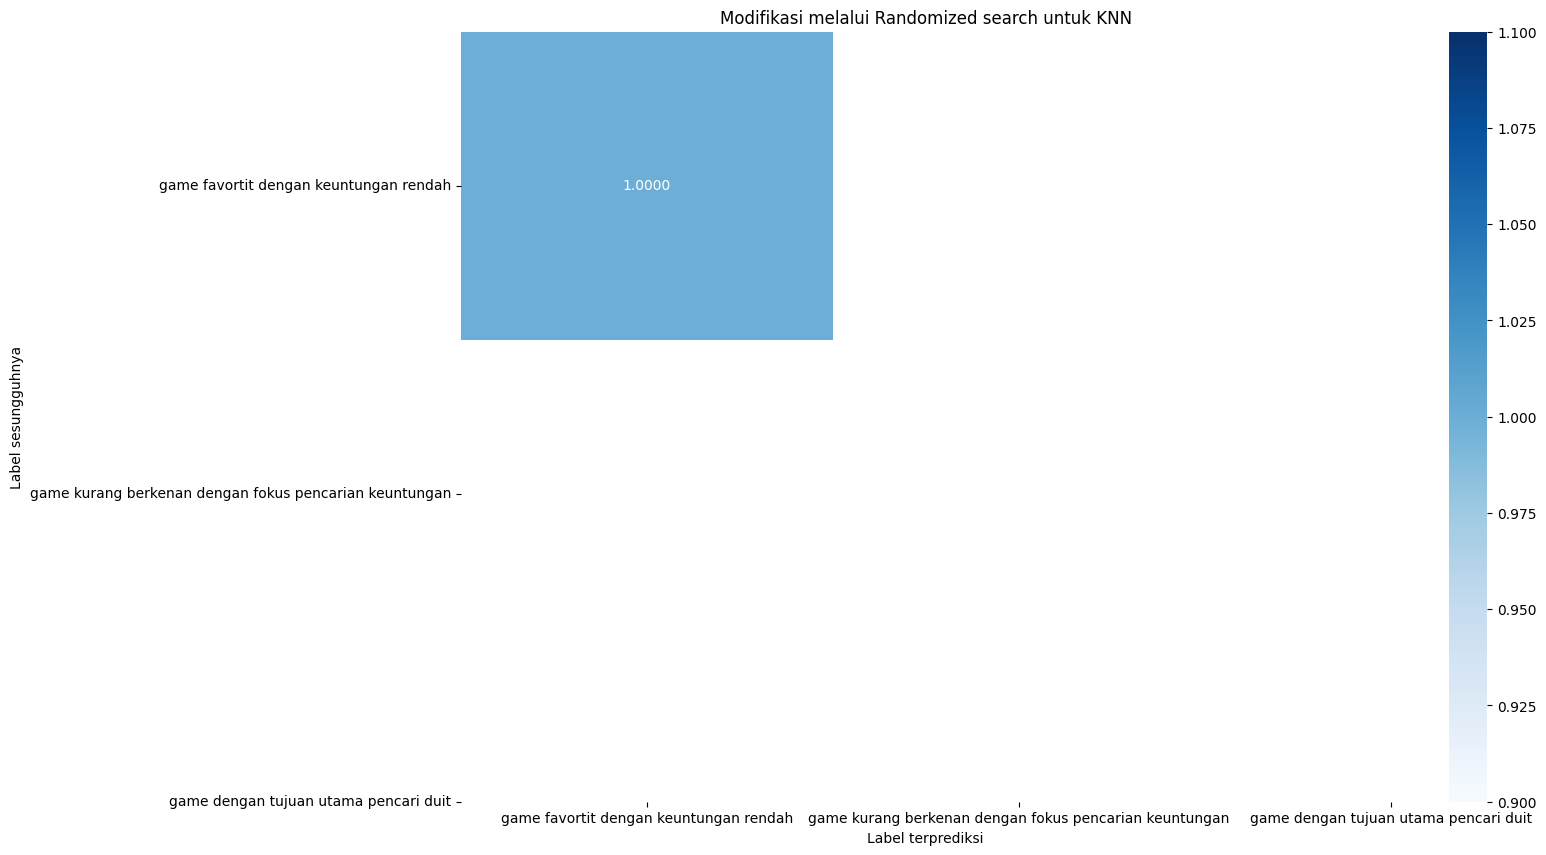

In [58]:
#Modifikasi melalui Randomized search [KNN]
plt.figure(figsize=(15, 10))
sns.heatmap(hslmoda, annot=True, fmt='.4f', cmap='Blues',
            xticklabels= label,  # Setel sesuai kelas
            yticklabels= label)  # Penyetaln kondisi
plt.ylabel('Label sesungguhnya')
plt.xlabel('Label terprediksi')
plt.title('Modifikasi melalui Randomized search untuk KNN')
plt.show()

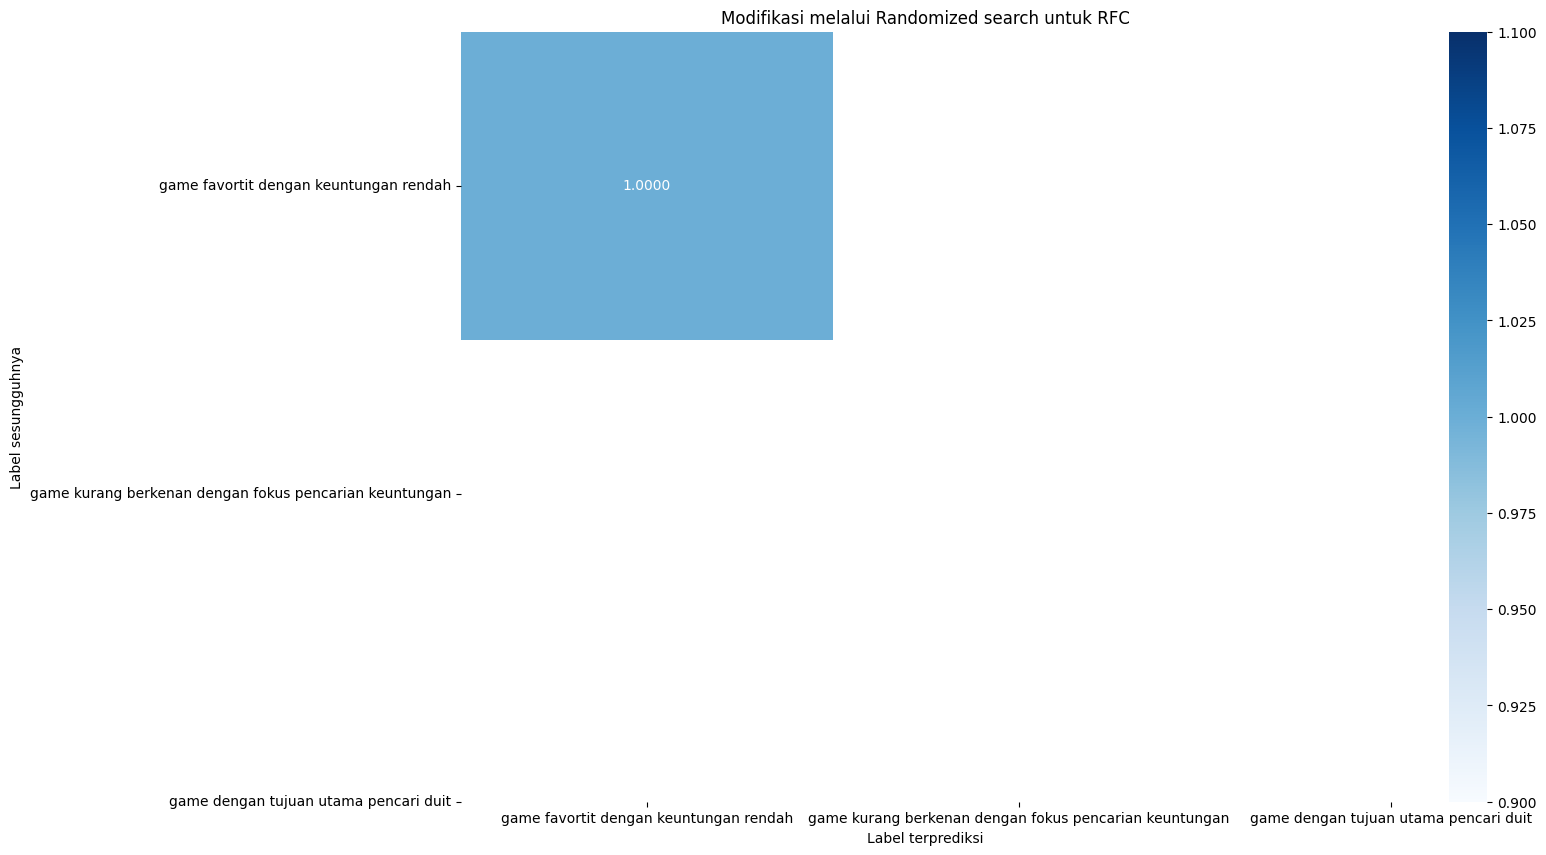

In [59]:
#Inspeksi matriks modifikasi melalui pencarian acak
plt.figure(figsize=(15, 10))
sns.heatmap(hslmodb, annot=True, fmt='.4f', cmap='Blues',
            xticklabels= label,  # Setel sesuai kelas
            yticklabels= label)  # Penyetaln kondisi
plt.ylabel('Label sesungguhnya')
plt.xlabel('Label terprediksi')
plt.title('Modifikasi melalui Randomized search untuk RFC')
plt.show()

In [61]:
#Fungsi pembulatan untuk inspeksi kurva pembelajaran
def round_scores(scores, decimals=3):
    return np.round(scores, decimals)

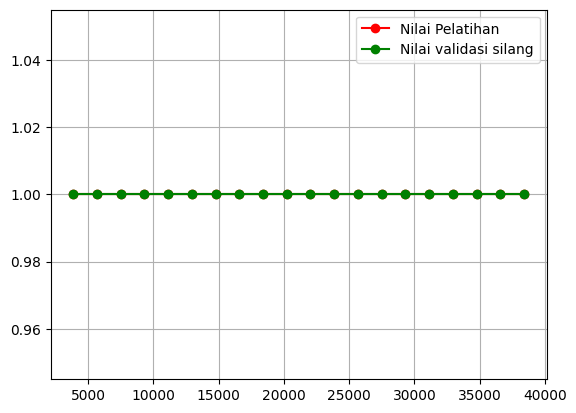

In [63]:
#Kurva Pembelajaran melalui KNN
train_sizes, train_scores, validation_scores = lencur(
    estimator= KNeighborsClassifier(n_neighbors=1, weights='distance', leaf_size=35,
                                 metric='seuclidean',p=1,metric_params={'V': np.var(X_train, axis=0)}), #Nilai terbaik
    X=X_train,
    y=y_train.ravel(),
    train_sizes=np.linspace(0.1, 1.0, 20),  # Increased number of points for smoother curve
    cv=5,
    scoring='accuracy'  # Ubah di akurasi
)
#Penghitungan rata-rata dan deviasi standar
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

train_scores_std = np.std(train_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Pembulatan melalui fungsi
train_scores_mean_rounded = round_scores(train_scores_mean, decimals=3)
validation_scores_mean_rounded = round_scores(validation_scores_mean, decimals=3)

#Ilustrasi (latihan)
plt.plot(train_sizes, train_scores_mean_rounded, 'o-', color="r", label="Nilai Pelatihan")
plt.fill_between(train_sizes,
                 round_scores(train_scores_mean - train_scores_std, decimals=3),
                 round_scores(train_scores_mean + train_scores_std, decimals=3),
                 alpha=0.1, color="r")

# Validasi
plt.plot(train_sizes, validation_scores_mean_rounded, 'o-', color="g", label="Nilai validasi silang")
plt.fill_between(train_sizes,
                 round_scores(validation_scores_mean - validation_scores_std, decimals=3),
                 round_scores(validation_scores_mean + validation_scores_std, decimals=3),
                 alpha=0.1, color="g")

plt.legend(loc="best")
plt.grid()
plt.show()

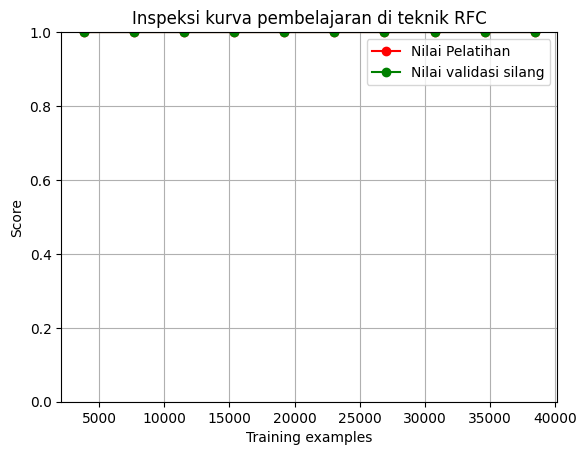

In [64]:
#Kurva pemberlajaran melalui metode 'analisis hutan' [normal]
final_model = RandomForestClassifier(random_state=50, ccp_alpha=best_alpha, class_weight=dictbrt ,warm_start=True)
# Generate learning curve data
train_sizes, train_scores, validation_scores = lencur(
    estimator=final_model,
    X=X_train_mmap,
    y=y_train.ravel(),
    train_sizes=np.linspace(0.1, 1.0, 10),  # Aspek yang akan dinilai
    cv=5,
    scoring='accuracy'  # You can change this to other metrics if needed
)

# Perhitungan nilai rata-rata dan
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

train_scores_std = np.std(train_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Round the mean scores for easier reading
train_scores_mean_rounded = np.round(train_scores_mean, decimals=3)
validation_scores_mean_rounded = np.round(validation_scores_mean, decimals=3)

# Ilustrasi Hasil melalui RFC
plt.figure()
plt.title("Inspeksi kurva pembelajaran di teknik RFC")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.ylim(0, 1)  # Adjust based on your score range

# Plot training scores
plt.plot(train_sizes, train_scores_mean_rounded, 'o-', color="r", label="Nilai Pelatihan")
plt.fill_between(train_sizes,
                 np.round(train_scores_mean - train_scores_std, decimals=3),
                 np.round(train_scores_mean + train_scores_std, decimals=3),
                 alpha=0.1, color="r")

# Plot validation scores
plt.plot(train_sizes, validation_scores_mean_rounded, 'o-', color="g", label="Nilai validasi silang")
plt.fill_between(train_sizes,
                 np.round(validation_scores_mean - validation_scores_std, decimals=3),
                 np.round(validation_scores_mean + validation_scores_std, decimals=3),
                 alpha=0.1, color="g")

plt.legend(loc="best")
plt.grid()
plt.show()

In [66]:
#Bagian Fungsi
def tuned_train_and_evaluate_with_learning_curve(X_train, y_train, X_test, y_test, brtsampel):
    # Check for NaN values in input data
    if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
        raise ValueError("There are NaN values in X_train or y_train.")
    if np.any(np.isnan(X_test)) or np.any(np.isnan(y_test)):
        raise ValueError("There are NaN values in X_test or y_test.")

    knn = KNeighborsClassifier(weights='distance', leaf_size=35, metric='euclidean', p=1, n_jobs=-1)

    # Define parameters for RandomizedSearchCV
    param_dist = {
        'n_neighbors': range(2, min(20, len(X_train))),
        'weights': ['uniform', 'distance'],
        'metric': ['seuclidean', 'cosine']
    }

    random_search = RandomizedSearchCV(knn, param_distributions=param_dist,
                                       verbose=1, n_iter=20, cv=5,
                                       random_state=40, n_jobs=-1)

    # Generate learning curve data
    train_sizes, train_scores, test_scores = learning_curve(random_search, X_train, y_train,
                                                            train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=5, shuffle=True)

    # Calculate mean and standard deviation for training scores
    train_scores_mean = np.nanmean(train_scores, axis=1)
    test_scores_mean = np.nanmean(test_scores, axis=1)

    # Handle potential NaN values in mean scores
    train_scores_mean[np.isnan(train_scores_mean)] = 0
    test_scores_mean[np.isnan(test_scores_mean)] = 0

    # Plotting the learning curve
    plt.figure()
    plt.title("Learning Curve with KNN")
    plt.xlabel("Training Samples")
    plt.ylabel("Score")

    plt.plot(train_sizes, train_scores_mean, label="Training Score", color="r")
    plt.plot(train_sizes, test_scores_mean, label="Cross-Validation Score", color="g")

    plt.fill_between(train_sizes,
                     np.nanmean(train_scores, axis=1) - np.nanstd(train_scores, axis=1),
                     np.nanmean(train_scores, axis=1) + np.nanstd(train_scores, axis=1), color="r", alpha=0.2)

    plt.fill_between(train_sizes,
                     np.nanmean(test_scores, axis=1) - np.nanstd(test_scores, axis=1),
                     np.nanmean(test_scores, axis=1) + np.nanstd(test_scores, axis=1), color="g", alpha=0.2)

    plt.legend(loc="best")
    plt.grid()
    plt.show()

    # Fit the model on the full training set
    random_search.fit(X_train, y_train)

    # Predictions and metrics
    y_pred = random_search.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")

In [ ]:
#Pemanggilan fungsi
if __name__ == '__main__':
    result = tuned_train_and_evaluate_with_learning_curve(X_train_mmap, y_trainr, X_test_mmap, y_test_mmap, brtsampel)

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

In [ ]:
#Pembuatan hasil K-nearest Neighborhood [Normal]
nilaik = [1, 3, 5, 6,7,9, 10]
#Ukuran Grafik
plt.figure(figsize=(14, 12))
# Iterasi nilai k
for i, k in enumerate(nilaik):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_trainr)

    # Create a mesh grid for plotting decision boundaries
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting decision boundary and training points
    plt.subplot(2, 3, i + 1)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_trainrav, edgecolors='k', marker='o')
    plt.title(f'Nilai KNN dengan fitur={k}')
    plt.xlabel('Bagian 1')
    plt.ylabel('Bagian 2')

plt.tight_layout()
plt.show()

###Aspek yang bisa dikembangkan untuk analisis Lanjutan
1. Hasil fitting untuk metode K-nearest Neighborhood (KNN) memiliki nilai akurasi yang sama untuk kondisi normal dengan kondisi dengan modifikasi Randomized seaech. Di sisi lain, kejadian hampir seupa juga muncul di analisis dengan metode Randomforestclassifier (RFC).
2. Dua metode tersebut (metode RFC dan KNN) memiliki nilai akurasi, presisi, aspek recall, dan skor F1 sempurna untuk satu kluster saja
  - Proses eksekusi menunjukan penandaan yang **'sangat tajam'** di satu kluster. Percobaan pertama menunjukan ketajaman di suatu kluster saja, sementara percobaan 2 menunju ke kluster lain.
  - Modifikasi dengan **'Randomizedsearch '** untuk dua metode memiliki peringatan tentang nilai 'nan' di inspeksi kurva pembelajaran
  - Semua model memliki kecendrungan untuk **'overfitting'** di kondisi normal maupun kondisi dengan 'Randomizedsearch'.
  - Bentuk kurva pemberlajaran
3. Saran untuk melakukan modifikasi :
  - Implementasikan kluster dengan banyak label di bagian pembentukan kluster dan klasifikasi untuk menghindari kasus ini
  - Terapkan berat sampel dalam nilai pasti untuk menghindari peringatan 'kluster'
